**Assignment 2** 

This assignment requires you to implement image recognition methods. Please understand and use relevant libraries. You are expected to solve both questions.

**Data preparation and rules**

Please use the images of the MNIST hand-written digits recognition dataset. You may use torchvision.datasets library to obtain the images and splits. You should have 60,000 training images and 10,000 test images. Use test images only to evaluate your model performance.


In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


In [3]:
from tensorflow.keras.datasets import mnist
import cv2
import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
print(train_images.shape)
print(test_images.shape)            

(60000, 28, 28)
(10000, 28, 28)


Q1: SIFT-BoVW-SVM [4 points]

1. [2 points] Implement the SIFT detector and descriptor. Compute cluster centers for the Bag-of-Visual-Words approach. Represent the images as histograms (of visual words) and train a linear SVM model for 10-way classification.
Note 1: You may want to use libraries such as cv2 (OpenCV) and sklearn (Sci-kit learn) for doing this question. https://scikit-learn.org/stable/modules/svm.html#multi-class-classification may be useful for the SVM.
Note 2: Seed random numbers for reproducibility (running the notebook again should give you the same results!).

In [5]:
from tensorflow.keras.datasets import mnist
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def preprocess_images(images):
    images = images.astype('float32') / 255.0
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

def calc_features(images, thresh):
    sift = cv2.SIFT_create(thresh)
    features = []
    for img in images:
        img = np.uint8(img * 255)  # Convert back to OpenCV usable format
        _, des = sift.detectAndCompute(img, None)
        if des is not None:
            features.append(des)
    return np.vstack(features) if features else np.empty((0, 128))  # Assuming SIFT descriptors have a length of 128


def perform_kmeans(features, k):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, _, centers = cv2.kmeans(features, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    return centers

def bag_of_features(features, centers, k):
    vec = np.zeros((1, k), dtype=np.float32)
    for i in range(features.shape[0]):
        diff = np.linalg.norm(np.tile(features[i], (k, 1)) - centers, axis=1)
        idx = np.argmin(diff)
        vec[0, idx] += 1
    return vec

def train_and_evaluate(train_images, train_labels, test_images, test_labels, thresh, k):
    features = calc_features(train_images, thresh)
    centers = perform_kmeans(features, k)
    
    def create_feature_vec(img):
        des = calc_features([img], thresh)
        if des.size > 0:  # Changed from None check to size check
            return bag_of_features(des, centers, k).flatten()
        else:
            return np.zeros((k,))  # Return a zero vector if no features are detected

    # Convert training and testing images to feature vectors
    train_vec = np.array([create_feature_vec(img) for img in train_images])
    test_vec = np.array([create_feature_vec(img) for img in test_images])
    
    # Train SVM
    clf = SVC(kernel='linear', probability=True)
    clf.fit(train_vec, train_labels)
    
    # Evaluate
    preds = clf.predict(test_vec)
    return accuracy_score(test_labels, preds), confusion_matrix(test_labels, preds)

thresh = 10  # SIFT feature threshold
k = 150  # Number of clusters for KMeans
accuracy, conf_mat = train_and_evaluate(train_images, train_labels, test_images, test_labels, thresh, k)

print(f'Accuracy: {accuracy*100:.2f}%')
print('Confusion Matrix:')
print(conf_mat)


Accuracy: 74.24%
Confusion Matrix:
[[ 835    6   20    1    1   38   54   10   10    5]
 [   2 1109    5    0    3    0    2   11    1    2]
 [  52   27  638   29   27   27   27  159   32   14]
 [  10    8   61  769   18   85   11   23   14   11]
 [   1   16   35   14  771   17   18   31   26   53]
 [  57   15   22   63   19  573   62   45   13   23]
 [  64   21   34   14    7   56  566   54   16  126]
 [  12   78  107   11   29   19   30  736    5    1]
 [  19    3   35   25   33   20   36    6  750   47]
 [  16   11   14   14   42   39  135   22   39  677]]


2. [1 point] Keeping everything else constant, plot how classification accuracy changes as you sweep across 6 different values for the number of clusters. Please decide what numbers are meaningful for this question. Explain the trends in classification accuracy that you observe.
Note 1: It is recommended to try hyperparameters in logarithmic steps such as 2x or 3x multiples. An example of 2x multiples is: 1, 2, 5, 10, 20, ... An example of 3x multiples is: 1, 3, 10, 30, 100, ...


In [26]:
# cluster_counts = [10, 30, 100, 300]
# accuracies = []

# for k in cluster_counts:
#     print(f"Evaluating for k = {k}")
#     accuracy, _ = train_and_evaluate(train_images, train_labels, test_images, test_labels, thresh, k)
#     accuracies.append(accuracy)
#     print(f"Accuracy for k = {k}: {accuracy*100:.2f}%")

# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(cluster_counts, accuracies, marker='o', linestyle='-', color='b')
# plt.title("Classification Accuracy vs Number of Clusters")
# plt.xlabel("Number of Clusters")
# plt.ylabel("Classification Accuracy")
# plt.xscale("log")  # Because we're using a logarithmic scale for cluster counts
# plt.grid(True, which="both", ls="--")
# plt.show()


3. [1 point] Show the results for 6 different hyperparameter settings. You may play with the SIFT detector or descriptor and the linear SVM. Keep the number of clusters constant based on the answer to the previous question. Explain the trends in classification accuracy that you observe.

In [ ]:
def calc_sift_features(images, nfeatures, contrastThreshold, edgeThreshold, nOctaveLayers):
    sift = cv2.SIFT_create(nfeatures=nfeatures, contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, nOctaveLayers=nOctaveLayers)
    descriptors = []
    for img in images:
        kp, desc = sift.detectAndCompute(img.astype(np.uint8), None)
        if desc is not None:
            descriptors.append(desc)
    if descriptors:
        descriptors = np.vstack(descriptors)
    else:
        descriptors = np.array([])
    return descriptors

sift_params_list = [
    {'nfeatures': 50, 'contrastThreshold': 0.04, 'edgeThreshold': 10, 'nOctaveLayers': 3},  # Example settings
    # Add more dictionaries for different sets of parameters
]

# Train and evaluate for each set of SIFT parameters
for sift_params in sift_params_list:
    # Calculate SIFT features for the entire dataset
    all_features = calc_sift_features(np.concatenate([train_images, test_images]), **sift_params)
    # Cluster features
    kmeans = calc_features(all_features)
    # Create histograms for training and testing sets
    X_train = (train_images, kmeans, sift_params)
    X_test = (test_images, kmeans, sift_params)
    # Train and evaluate the SVM
    accuracy = train_and_evaluate(X_train, train_labels, X_test, test_labels, C=1.0)  # Adjust C as needed
    print(f"SIFT Params: {sift_params}, Accuracy: {accuracy}")

    
def train_and_evaluate_svm_for_c_values(X_train, y_train, X_test, y_test, C_values):
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for C in C_values:
        clf = SVC(C=C, kernel='linear', random_state=42)
        clf.fit(X_train_scaled, y_train)
        predictions = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, predictions)
        print(f"SVM C={C}, Accuracy: {accuracy}")

# Train and evaluate for each C value
train_and_evaluate_svm_for_c_values(X_train, y_train, X_test, y_test, C_values)

Q2: CNNs and Transformers [6 points]
1. [2.5 points] Set up a modular codebase for training a CNN (LeNet) on the task of handwritten digit recognition. You should have clear functional separation between the data (dataset and dataloader), model (nn.Module), and trainer (train/test epoch loops). Implement logging: using Weights & Biases is highly recommended, alternatively, create your own plots using other plotting libraries. Log the training and evaluation losses and accuracies at every epoch, show the plots for at least one training and evaluation run.
Note 1: Seed random numbers for reproducibility (running the notebook again should give you the same results!).


In [8]:
import wandb

# Initialize W&B project
wandb.init(project="CV-Assignment-2")

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_data(batch_size=64):
    transform = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

    # Download and load the training data
    trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Download and load the test data
    testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

    return trainloader, testloader


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # Input channel, Output channels, Kernel size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_and_evaluate(model, trainloader, testloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()
                for images, labels in testloader:
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {running_loss/len(trainloader):.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

# Main script
if __name__ == "__main__":
    torch.manual_seed(42)  # For reproducibility
    trainloader, testloader = load_data()
    model = LeNet()
    train_and_evaluate(model, trainloader, testloader)
    torch.save(model.state_dict(), 'lenet_mnist.pth')


Epoch 1/10.. Train loss: 0.234.. Test loss: 0.073.. Test accuracy: 0.976
Epoch 2/10.. Train loss: 0.064.. Test loss: 0.060.. Test accuracy: 0.981
Epoch 3/10.. Train loss: 0.045.. Test loss: 0.037.. Test accuracy: 0.988
Epoch 4/10.. Train loss: 0.037.. Test loss: 0.035.. Test accuracy: 0.988
Epoch 5/10.. Train loss: 0.030.. Test loss: 0.039.. Test accuracy: 0.987


KeyboardInterrupt: 

2. [1 point] Show the results for 6 different settings of hyperparameters. You may want to change the batch size, learning rate, and optimizer. Explain the trends in classification accuracy that you observe. Which hyperpa- rameters are most important?


In [3]:
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_and_evaluate(batch_size, learning_rate, optimizer_choice, epochs=5, momentum=0.9, weight_decay=0.0):
 
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


    model = LeNet()
    criterion = nn.CrossEntropyLoss()

    optimizer = None
    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_choice == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(trainloader):.4f}")

  
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy:.2f}%")
    return accuracy


In [4]:

# Hyperparameters sets to experiment with
hyperparameters_sets = [
    {'batch_size': 32, 'learning_rate': 0.001, 'optimizer_choice': 'Adam'},
    {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer_choice': 'Adam'},
    {'batch_size': 64, 'learning_rate': 0.002, 'optimizer_choice': 'Adam'},
    {'batch_size': 128, 'learning_rate': 0.001, 'optimizer_choice': 'SGD', 'momentum': 0.9},
    {'batch_size': 128, 'learning_rate': 0.005, 'optimizer_choice': 'SGD', 'momentum': 0.5},
    {'batch_size': 256, 'learning_rate': 0.001, 'optimizer_choice': 'RMSprop'},
    {'batch_size': 256, 'learning_rate': 0.0005, 'optimizer_choice': 'RMSprop'},
    {'batch_size': 512, 'learning_rate': 0.001, 'optimizer_choice': 'Adam'},
    {'batch_size': 64, 'learning_rate': 0.001, 'optimizer_choice': 'Adam', 'weight_decay': 0.0001},
    {'batch_size': 128, 'learning_rate': 0.0001, 'optimizer_choice': 'Adam', 'weight_decay': 0.001},
    {'batch_size': 128, 'learning_rate': 0.001, 'optimizer_choice': 'SGD', 'momentum': 0.9, 'weight_decay': 0.0001},
]



def train_and_evaluate_with_wandb(hparams):
    wandb.init(project="hyperparameter_tuning", config=hparams)
    config = wandb.config
    accuracy = train_and_evaluate(batch_size=config.batch_size, learning_rate=config.learning_rate, optimizer_choice=config.optimizer_choice, momentum=config.get('momentum', 0), weight_decay=config.get('weight_decay', 0))
    wandb.log({"accuracy": accuracy})
    wandb.finish()
    return accuracy

def perform_grid_search(hyperparameters_sets):
    best_accuracy = 0
    best_hyperparameters = None
    results = []

    for hparams in hyperparameters_sets:
        print(f"Experiment with params {hparams}")
        accuracy = train_and_evaluate_with_wandb(hparams)
        results.append({'params': hparams, 'accuracy': accuracy})

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = hparams

    print(f"Best performing hyperparameters: {best_hyperparameters}")
    print(f"Best accuracy: {best_accuracy:.2f}%")
    return best_hyperparameters, best_accuracy, results

best_hyperparameters, best_accuracy, results = perform_grid_search(hyperparameters_sets)

accuracies = [result['accuracy'] for result in results]
labels = [f"Exp {i+1}" for i, _ in enumerate(results)]

plt.figure(figsize=(12, 8))
bars = plt.bar(labels, accuracies, color='skyblue')
plt.xlabel('Experiment')
plt.ylabel('Accuracy (%)')
plt.title('Grid Search Results')
plt.xticks(rotation=45)

# Annotating each bar with its height value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

plt.show()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Experiment with params {'batch_size': 32, 'learning_rate': 0.001, 'optimizer_choice': 'Adam'}


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/sunayana/.netrc


RuntimeError: shape '[-1, 400]' is invalid for input of size 8192

3. [0.5 points] Compare the best performing CNN (from above) against the SIFT-BoVW-SVM approach. Explain the differences.

CNN's best performance comes to arouny
d 99 percent whereas the maximum SIFT-BOVW-SVM reaches is around 80 percent. The later approach has lower accuracy in general as it manually extracts and quantizes the features each time. It also has a higher run time compared to CNNs. 

| Feature | CNN | SIFT-BoVW-SVM |
|---------|-----|---------------|
| **Feature Extraction** | Automatically learns from data, capturing hierarchical patterns. | Manually extracts and quantizes local features. |
| **Classification Strategy** | Includes an integrated classification layer. | Uses SVM classifier based on quantized feature vectors. |
| **Performance** | Tends to outperform on complex image classification tasks due to end-to-end learning. | Can be effective in scenarios with limited data or where local features are crucial, but generally lags behind CNNs. |
| **Use Cases** | Preferred for a wide range of image classification tasks, requires large datasets. | Suitable for tasks benefiting from robustness to scale and rotation, or where computational resources are limited. |


4. [0.5 points] How does the performance change if you double the number of convolutional layers?


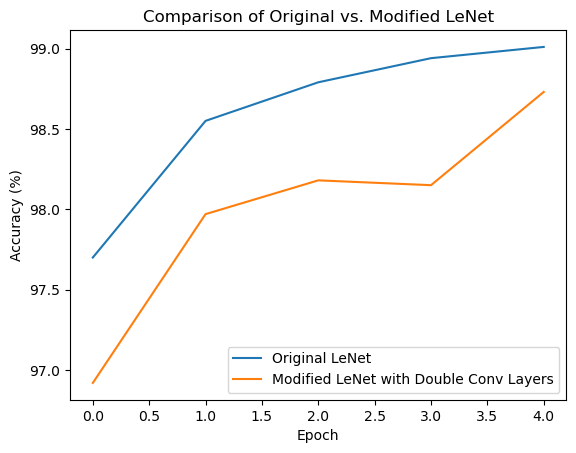

In [24]:
import torch.nn.functional as F


class ModifiedLeNet(nn.Module):
    def __init__(self):
        super(ModifiedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv1_1 = nn.Conv2d(6, 6, 5, padding=2) # Additional layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_1 = nn.Conv2d(16, 16, 5, padding=2) # Additional layer
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv1_1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv2_1(x))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train_and_evaluate(model_class, batch_size, learning_rate, optimizer_choice, epochs=5):

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


    model = model_class()
    criterion = nn.CrossEntropyLoss()

    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_choice == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Evaluation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        
    return accuracies

# Common hyperparameters
batch_size = 64
learning_rate = 0.001
optimizer_choice = 'Adam'


original_accuracies = train_and_evaluate(model_class=LeNet, batch_size=batch_size, learning_rate=learning_rate, optimizer_choice=optimizer_choice, epochs=5)

modified_accuracies = train_and_evaluate(model_class=ModifiedLeNet, batch_size=batch_size, learning_rate=learning_rate, optimizer_choice=optimizer_choice, epochs=5)

# Plotting
plt.plot(original_accuracies, label='Original LeNet')
plt.plot(modified_accuracies, label='Modified LeNet with Double Conv Layers')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Original vs. Modified LeNet')
plt.legend()
plt.show()


5. [0.5 points] How does the performance change as you increase the number of training samples: [0.6K, 1.8K, 6K, 18K, 60K]? Explain the trends in classification accuracy that you observe.
Note 1: Make sure that all classes are represented equally within different subsets of the training sets.


Training with subset size: 600


Accuracy: 81.83%

Training with subset size: 1800


Accuracy: 90.48%

Training with subset size: 6000


Accuracy: 96.24%

Training with subset size: 18000


Accuracy: 97.72%

Training with subset size: 60000


Accuracy: 98.67%



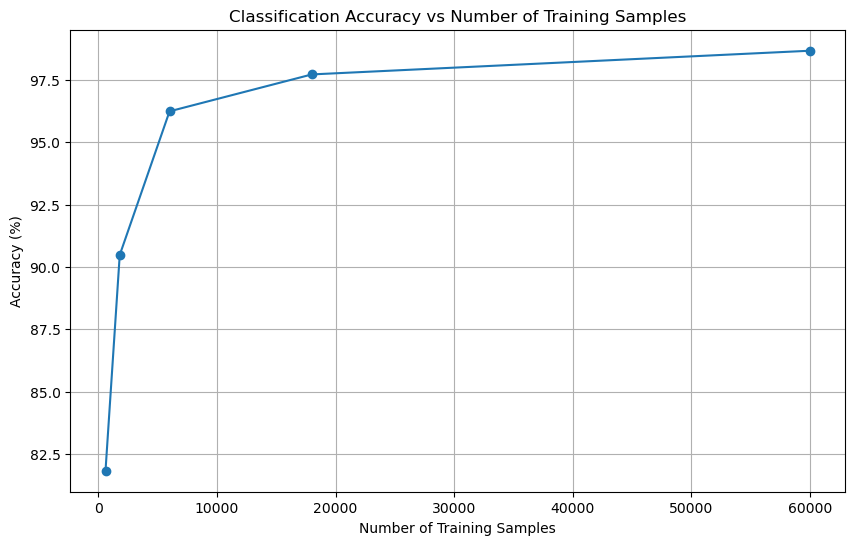

In [25]:
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import numpy as np
import torchvision.transforms as transforms

def create_balanced_subset(dataset, subset_size_per_class=100):
    targets = np.array(dataset.targets)
    indices = []

    for class_idx in range(10):  # MNIST has 10 classes
        class_indices = np.where(targets == class_idx)[0]
        np.random.shuffle(class_indices)
        indices.extend(class_indices[:subset_size_per_class])

    np.random.shuffle(indices)
    return Subset(dataset, indices)


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_and_evaluate(model_class, train_loader, test_loader, optimizer_choice, epochs=5, learning_rate=0.001):
    model = model_class()
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_choice == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    accuracies = []

    for epoch in range(epochs):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
    
    return accuracies[-1]  # Return accuracy of the last epoch for simplicity

subset_sizes = [600, 1800, 6000, 18000, 60000]  # Adjusted for balanced subsets across 10 classes
results = []

for size in subset_sizes:
    subset_size_per_class = size // 10
    balanced_train_dataset = create_balanced_subset(full_train_dataset, subset_size_per_class)
    train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
    
    print(f"Training with subset size: {size}")
    accuracy = train_and_evaluate(LeNet, train_loader, test_loader, 'Adam', epochs=5)
    results.append(accuracy)
    print(f"Accuracy: {accuracy}%\n")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, results, marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy (%)')
plt.title('Classification Accuracy vs Number of Training Samples')
plt.grid(True)
plt.show()


6. [1 point] Replace the CNN model with a 2 layer TransformerEncoder. Using a ViT style prediction scheme, evaluate classification accuracy when training with 6K and 60K images. How do the results compare against CNNs? Explain the trends.

In [13]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np


transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)) 
])


full_train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

small_train_dataset = Subset(full_train_dataset, np.random.choice(len(full_train_dataset), 6000, replace=False))

test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
small_train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [17]:
import torch
from torch import nn

class ViT(nn.Module):
    def __init__(self, image_size=28, patch_size=7, num_classes=10, dim=128, depth=6, heads=8, mlp_dim=256):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2
        patch_dim = patch_size * patch_size * 1  # '1' for the number of channels in MNIST images
        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Create a transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        # Stack multiple layers into a transformer encoder
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img):
        # Reshape img to patches without einops
        batch_size, channels, height, width = img.shape
        p = self.patch_size
        img = img.unfold(2, p, p).unfold(3, p, p)  # Create patches
        img = img.contiguous().view(batch_size, -1, p * p * channels)  # Reshape to [batch_size, num_patches, patch_dim]

        x = self.patch_to_embedding(img)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(x.size(1))]
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)


In [20]:
import torch
from torch import nn
import torch.optim as optim

def train_and_evaluate(model, train_loader, test_loader, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # List to store accuracy per epoch
    accuracy_per_epoch = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracy_per_epoch.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy on the test set: {accuracy:.2f}%')

    return accuracy_per_epoch


In [21]:
vit_model_small = ViT()
vit_model_full = ViT()

accuracies_small_dataset = []
accuracies_full_dataset = []

print("Training ViT on small dataset")
accuracies_small_dataset = train_and_evaluate(vit_model_small, small_train_loader, test_loader, epochs=10)

print("\nTraining ViT on full dataset")
accuracies_full_dataset = train_and_evaluate(vit_model_full, full_train_loader, test_loader, epochs=10)


Training ViT on small dataset
Epoch 1, Loss: 1.6951778353528772
Epoch 1, Accuracy on the test set: 67.02%
Epoch 2, Loss: 0.6363104724503578
Epoch 2, Accuracy on the test set: 87.01%
Epoch 3, Loss: 0.39881180591405707
Epoch 3, Accuracy on the test set: 89.71%
Epoch 4, Loss: 0.2967303366737163
Epoch 4, Accuracy on the test set: 93.60%
Epoch 5, Loss: 0.23990465423211138
Epoch 5, Accuracy on the test set: 92.42%
Epoch 6, Loss: 0.20916587090555658
Epoch 6, Accuracy on the test set: 93.73%
Epoch 7, Loss: 0.1878132950514555
Epoch 7, Accuracy on the test set: 93.72%
Epoch 8, Loss: 0.15276464376043766
Epoch 8, Accuracy on the test set: 93.50%
Epoch 9, Loss: 0.14063390112541457
Epoch 9, Accuracy on the test set: 94.01%
Epoch 10, Loss: 0.11832679025432531
Epoch 10, Accuracy on the test set: 94.29%

Training ViT on full dataset
Epoch 1, Loss: 0.48091244304191266
Epoch 1, Accuracy on the test set: 94.17%
Epoch 2, Loss: 0.17842635018989317
Epoch 2, Accuracy on the test set: 96.14%
Epoch 3, Loss: 0.1

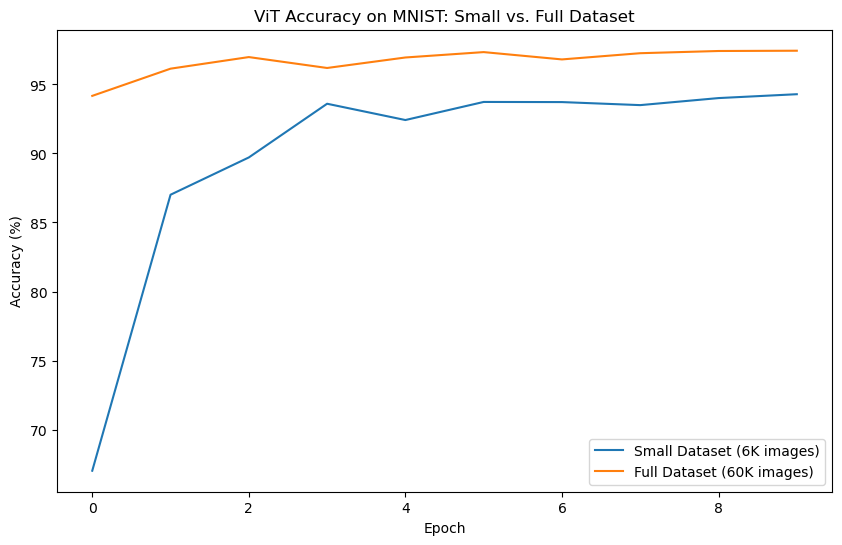

In [22]:
import matplotlib.pyplot as plt

# Plot settings
plt.figure(figsize=(10, 6))
plt.plot(accuracies_small_dataset, label='Small Dataset (6K images)')
plt.plot(accuracies_full_dataset, label='Full Dataset (60K images)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('ViT Accuracy on MNIST: Small vs. Full Dataset')
plt.legend()
plt.show()


The analysis of Vision Transformers (ViTs) and Convolutional Neural Networks (CNNs) across various dataset sizes yields key insights into their performance:

- **ViT Highlights:**
  - Exhibits significant improvement and adaptability on a small dataset (6K images), with accuracy jumping from 67.02% to 94.29%.
  - Scales well with a larger dataset (60K images), achieving a notable accuracy increase from 94.17% to 97.44%.

- **CNN Highlights:**
  - Shows consistent performance growth with increasing dataset sizes, starting at 81.83% accuracy (600 images) and peaking at 98.67% (60K images).

- **Comparative Analysis:**
  - ViTs demonstrate strong scalability and adaptability, challenging the notion they solely excel with massive datasets.
  - CNNs slightly outperform ViTs in peak accuracy on the full dataset but ViTs show promising efficiency across dataset sizes.

In summary, while both architectures improve with more data, ViTs' performance on smaller datasets is notably impressive. Despite CNNs achieving marginally higher maximum accuracy, the gap narrows, affirming ViTs as a competitive alternative for image classification tasks.
